**This notebook shows how to read data from a "zarr" dataset, calculate fog and low clouds frequency, and create timeseries plots.**

Author: Autumn Nguyen and Eli Schwat.
Version: July 2023.

While the original dataset comprises of many raster files, each file representing an image from a single timestamp, the "zarr" dataset is a file that stores data in time series, each timeseries containing all the values of each pixel, or each small group of pixels, at all timestamps that the raster files originally come in.

In [50]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

from dask.distributed import Client, LocalCluster


In [51]:
def plot_from_globe_shoreline(bounds):
	# In GSHHS_h_L1, h means high resolution, L1 means land and ocean boundaries.
	shoreline = gpd.read_file("/storage/ngoc54n/global_shoreline/GSHHS_shp/h/GSHHS_h_L1.shp")
	shoreline["geometry"] = shoreline.clip_by_rect(*bounds)
	# Keep only the non-empty items
	shoreline = shoreline[~ shoreline["geometry"].is_empty]
	shoreline.reset_index(inplace=True) # reset the index after removing empty items
	
	# We only want the vector points of the boundaries between land and ocean, not the vector points for all points that are land and all that are oceans
	# so we have to get the Linestrings/MultiLinestrings objects from Polygon/MultiPolygon objects
	# The first two items are MultiPolygons, and the rest are Polygons
	
	for i in range(2):
		shoreline.loc[i, 'geometry'] = MultiPolygon(shoreline.loc[i, 'geometry']).boundary
	for i in range(2, shoreline['geometry'].size):
		shoreline.loc[i, 'geometry'] = Polygon(shoreline.loc[i, 'geometry']).boundary
		# .loc[row_indexer, col_indexer] works, while .iloc[col_indexer][row_indexer] will throw an error of "A value is trying to be set on a copy of a slice from a DataFrame."

	return shoreline

In [52]:
# Because plot_shoreline.py is in a directory above where this notebook is, we need to import the sys module and add the path to the parent directory to the path list
import sys
sys.path.append('..')
# from plot_shoreline import plot_from_globe_shoreline

In [53]:
bounds = (-125, 46, -122, 49)
# shoreline = plot_from_globe_shoreline(bounds)

### Start a Dask Cluster 

In [54]:
# Create a Dask cluster so we can watch the dask dashboard
workers = 6
ip_addres = 'http://j-lundquist-3.ce.washington.edu'
port=':8787'
threads = 2
cluster = LocalCluster(n_workers=workers, threads_per_worker=threads, dashboard_address=port)
client = Client(cluster)

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33717 instead
  warnings.warn(


### Open all raster files from zarr

In [55]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 50, 'longitude': 50},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

/tmp/ipykernel_1575515/1982344818.py:2: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(
/tmp/ipykernel_1575515/1982344818.py:2: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(


In [56]:
ds

<xarray.Dataset> Size: 13GB
Dimensions:      (time: 40785, latitude: 284, longitude: 284)
Coordinates:
  * latitude     (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude    (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0
  * time         (time) datetime64[ns] 326kB 2022-04-30T17:01:17 ... 2022-09-...
Data variables:
    Height       (time, latitude, longitude) float32 13GB dask.array<chunksize=(40785, 50, 50), meta=np.ndarray>
    spatial_ref  (time) int64 326kB dask.array<chunksize=(40785,), meta=np.ndarray>
    time (UTC)   (time) datetime64[ns] 326kB dask.array<chunksize=(40785,), meta=np.ndarray>

In [57]:
bounds = ds.rio.bounds()

In [58]:
ds['Height']

<xarray.DataArray 'Height' (time: 40785, latitude: 284, longitude: 284)> Size: 13GB
dask.array<open_dataset-Height, shape=(40785, 284, 284), dtype=float32, chunksize=(40785, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0
  * time       (time) datetime64[ns] 326kB 2022-04-30T17:01:17 ... 2022-09-30...
Attributes:
    grid_mapping:  spatial_ref

### Get the datetimes from the file names to replace the time index in the dataset
because zarr has a bug that does not allow it to save `datetime64[ns]` objects correctly (precision is lost for hours and minutes)

In [59]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*_o.nc"))
files[0] # Take a look at the path of one file

'/storage/GOES/orthorectified/Fog2022_withtime/OR_ABI-L2-ACHAC-M6_G17_s20222440001177_e20222440003550_c20222440007138_o.nc'

In [60]:
datetimes = [
    dt.datetime.strptime(
        f.split('_')[4][1:-1], # parse the start time (the part "s2022__________" in the file name)
        "%Y%j%H%M%S"
    ) for f in files
]
''' The files in zarr are already sorted chronologically, 
but the files in the image_folder directory are not, 
so the datetimes info parsed from the directory also have to be sorted.'''
datetimes = sorted(datetimes)

In [61]:
ds['time'] = datetimes

In [62]:
# Take a look at the datetime objects
# pd.to_datetime(ds['time'])

## Clinton's code

In [63]:
ds.Height

<xarray.DataArray 'Height' (time: 40785, latitude: 284, longitude: 284)> Size: 13GB
dask.array<open_dataset-Height, shape=(40785, 284, 284), dtype=float32, chunksize=(40785, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0
  * time       (time) datetime64[ns] 326kB 2022-05-01T00:01:17 ... 2022-09-30...
Attributes:
    grid_mapping:  spatial_ref

In [64]:
# Select a specific latitude and longitude pixel
lat = 48.5  # Replace with the desired latitude
lon = -123.5  # Replace with the desired longitude
pixel_data = ds.Height.sel(latitude=lat, longitude=lon, method="nearest")

# Plot the data with time on the x-axis
plt.figure(figsize=(10, 6))
pixel_data.plot(marker='o', linestyle='-')
plt.title(f"Height at Latitude {lat}, Longitude {lon}")
plt.xlabel("Time")
plt.ylabel("Height")
plt.grid()
plt.show()

Task exception was never retrieved
future: <Task finished name='Task-10503371' coro=<Client._gather.<locals>.wait() done, defined at /home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Extract time values where pixel_data is NaN
nan_times = pixel_data['time'][np.isnan(pixel_data)]

# Plot the NaN times
plt.figure(figsize=(10, 6))
plt.plot(nan_times, [1] * len(nan_times), 'rx', label='NaN Values')  # Mark NaN times with red 'x'
plt.title("Time Points Where Pixel Data is NaN")
plt.xlabel("Time")
plt.yticks([])  # Remove y-axis ticks since it's not meaningful here
plt.legend()

KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'

## Frequency when NaNs are ignored

In [65]:
# We choose 2000 meters as the threshold for cloud top height to be considered fog or low cloud
ds['FLCC'] = (ds['Height'] < 2000) # Create a new array for ds which has 1s where Height is < 400 meters and 0s otherwise. NaN values are also represented as 0s here.
nan_indices = ds['Height'].isnull() # xarray's isnull() returns a boolean array indicated which item in ds['Height] has a missing value
'''Filter the array: keep the items that pass the condition. The items which don't pass will be replaced with NaNs.
This is xarray's where(), very different from numpy's where(). '''
not_nan_indices = ~nan_indices
ds['FLCC'] = ds['FLCC'].where(not_nan_indices) # Change the False values in FLCC which were originally NaNs in Height back to NaNs in FLCC

In [66]:
# sanity check to see if we are computing the values related to NaNs correctly
nans = (nan_indices == 1).sum().values # number of pixels that are NaNs
not_nans = (not_nan_indices == 1).sum().values # number of pixels that are not NaNs
total_pixels = 284*284*40785 # total number of pixels in 40785 rasters
print(nans, not_nans, total_pixels)
print('Expecting 0, get: ', total_pixels - (nans + not_nans))

854017213 2435537747 3289554960
Expecting 0, get:  0


In [ ]:
ds['time'].size

40785

In [ ]:
ds['not_nans'] = ~ds['Height'].isnull()

In [ ]:
FLCC_freq = (
    ds['FLCC'].sum(dim='time') / ds['not_nans'].sum(dim='time')
)
# Because we are working with Dask arrays in this dataset, frequency data won't actually be calculated until .load() is called in the cell below. The output of this cell is just a preview of what FLCC_freq will look like.

In [ ]:
# We call load to get this in memory right away - then plotting doesn't take a long time.
FLCC_freq.load()

<xarray.DataArray (latitude: 284, longitude: 284)> Size: 645kB
array([[0.23759719, 0.23759719, 0.23759719, ..., 0.09057698, 0.09057698,
        0.09057698],
       [0.23759719, 0.23759719, 0.23759719, ..., 0.09057698, 0.09057698,
        0.09057698],
       [0.23759719, 0.23759719, 0.23759719, ..., 0.09057698, 0.09057698,
        0.09057698],
       ...,
       [0.58344401, 0.58344401, 0.58344401, ..., 0.10865664, 0.10865664,
        0.10865664],
       [0.58344401, 0.58344401, 0.58344401, ..., 0.10865664, 0.10865664,
        0.10865664],
       [0.58344401, 0.58344401, 0.58344401, ..., 0.10865664, 0.10865664,
        0.10865664]])
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0

In [ ]:
FLCC_freq.max()

<xarray.DataArray ()> Size: 8B
array(0.58843239)

Text(0.5, 1.0, 'Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs ignored')

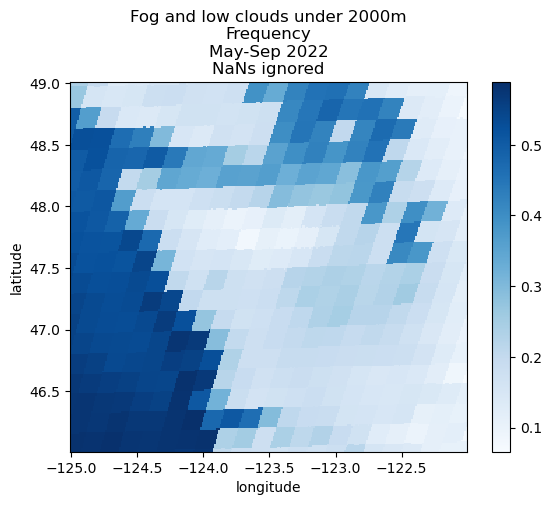

In [ ]:
fig, ax = plt.subplots()

FLCC_freq.plot(ax = ax, cmap = 'Blues')
# shoreline.plot(ax = ax, color = "black", alpha = 0.5) # how to make the stroke of the shoreline thinner?
plt.title('Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs ignored')

## Frequency when NaNs are not ignored

### Fog low cloud frequency, with NaNs not ignored but counted as clear sky

In [ ]:
# For calculating frequency of fog or low clouds
ds['FLCC'] = (ds['Height'] < 2000).astype(int)
FLCC_freq = (
    ds['FLCC'].sum(dim='time') / ds['time'].size
)

In [ ]:
FLCC_freq.load() # took 10 mins to run

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)> Size: 645kB
array([[0.16932696, 0.16932696, 0.16932696, ..., 0.05896776, 0.05896776,
        0.05896776],
       [0.16932696, 0.16932696, 0.16932696, ..., 0.05896776, 0.05896776,
        0.05896776],
       [0.16932696, 0.16932696, 0.16932696, ..., 0.05896776, 0.05896776,
        0.05896776],
       ...,
       [0.49545176, 0.49545176, 0.49545176, ..., 0.06235135, 0.06235135,
        0.06235135],
       [0.49545176, 0.49545176, 0.49545176, ..., 0.06235135, 0.06235135,
        0.06235135],
       [0.49545176, 0.49545176, 0.49545176, ..., 0.06235135, 0.06235135,
        0.06235135]])
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0

In [ ]:
FLCC_freq.max()

<xarray.DataArray 'FLCC' ()> Size: 8B
array(0.56864043)

Text(0.5, 1.0, 'Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs counted as clear sky')

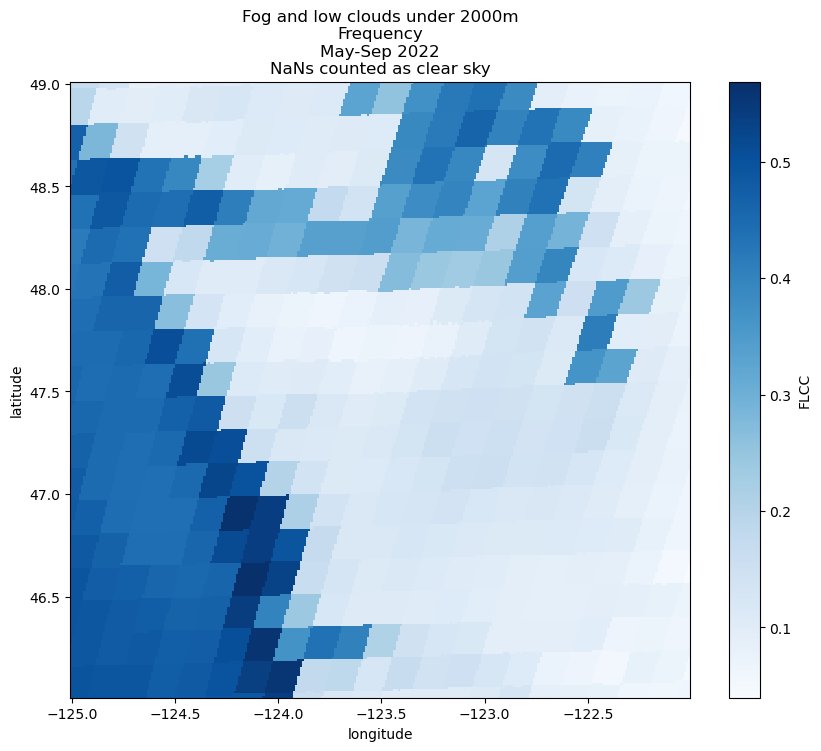

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

FLCC_freq.plot(ax = ax, cmap = 'Blues')
# shoreline.plot(ax = ax, color = "black", alpha = 0.5)
plt.title('Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs counted as clear sky')

### High clouds or Clear sky frequency (NaN not ignored)

In [ ]:
# For calculating frequency of high clouds or clear sky
ds['High_or_Clear'] = (ds['Height'] > 2000).astype(int)
nan_indices = ds['Height'].isnull() # xarray's isnull() returns a boolean array indicated which item in ds['Height] has a missing value
'''Filter the array: keep the items that pass the condition. The items which don't pass will be replaced with NaNs.
This is xarray's where(), very different from numpy's where(). '''
not_nan_indices = ~nan_indices
ds['High_or_Clear'] = ds['High_or_Clear'].where(not_nan_indices, 1) # Change the False values in FLCC which were originally NaNs in Height to True in FLCC
highclear_freq = (
    ds['High_or_Clear'].sum(dim='time') / ds['time'].size
)

In [ ]:
highclear_freq.load()

<xarray.DataArray 'High_or_Clear' (latitude: 284, longitude: 284)> Size: 645kB
array([[0.83067304, 0.83067304, 0.83067304, ..., 0.94103224, 0.94103224,
        0.94103224],
       [0.83067304, 0.83067304, 0.83067304, ..., 0.94103224, 0.94103224,
        0.94103224],
       [0.83067304, 0.83067304, 0.83067304, ..., 0.94103224, 0.94103224,
        0.94103224],
       ...,
       [0.50454824, 0.50454824, 0.50454824, ..., 0.93764865, 0.93764865,
        0.93764865],
       [0.50454824, 0.50454824, 0.50454824, ..., 0.93764865, 0.93764865,
        0.93764865],
       [0.50454824, 0.50454824, 0.50454824, ..., 0.93764865, 0.93764865,
        0.93764865]])
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0

Text(0.5, 1.0, 'High clouds or Clear sky (NaNs)\nFrequency\nMay-Sep 2022\n')

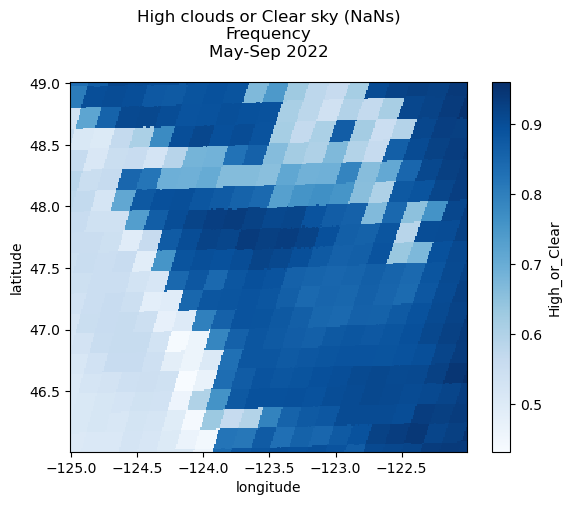

In [ ]:
fig, ax = plt.subplots()

highclear_freq.plot(ax = ax, cmap = 'Blues')
# shoreline.plot(ax = ax, color = "black", alpha = 0.5) # how to make the stroke of the shoreline thinner?
plt.title('High clouds or Clear sky (NaNs)\nFrequency\nMay-Sep 2022\n')

### Frequency during different times in a day

In [ ]:
# documentation about indexing using datetime components: https://docs.xarray.dev/en/stable/user-guide/time-series.html#indexing-using-datetime-components
# Select images taken from 5am to the end of 9am for see fog frequency in the morning
morning_ds = ds.isel(time=ds.time.dt.hour.isin([5,6,7,8,9])) 
# Select images taken from 10am to the end of 2pm for see fog frequency during midday
midday_ds = ds.isel(time=ds.time.dt.hour.isin([10,11,12,1,2]))
# Select images taken from 3pm to the end of 7pm for see fog frequency in the afternoon
afternoon_ds = ds.isel(time=ds.time.dt.hour.isin([3,4,5,6,7]))

In [ ]:
print(morning_ds['time'].size)
print(midday_ds['time'].size)
print(afternoon_ds['time'].size)

7209
8169
8192


In [ ]:
morning_freq = (
    morning_ds['FLCC'].sum(dim='time') / morning_ds['time'].size
)

In [ ]:
morning_freq.load() # took 5 min to run

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)> Size: 645kB
array([[0.16507144, 0.16507144, 0.16507144, ..., 0.02843668, 0.02843668,
        0.02843668],
       [0.16507144, 0.16507144, 0.16507144, ..., 0.02843668, 0.02843668,
        0.02843668],
       [0.16507144, 0.16507144, 0.16507144, ..., 0.02843668, 0.02843668,
        0.02843668],
       ...,
       [0.53322236, 0.53322236, 0.53322236, ..., 0.04896657, 0.04896657,
        0.04896657],
       [0.53322236, 0.53322236, 0.53322236, ..., 0.04896657, 0.04896657,
        0.04896657],
       [0.53322236, 0.53322236, 0.53322236, ..., 0.04896657, 0.04896657,
        0.04896657]])
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0

In [ ]:
midday_freq = (
    midday_ds['FLCC'].sum(dim='time') / midday_ds['time'].size
)

In [ ]:
midday_freq.load()

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)> Size: 645kB
array([[0.14934509, 0.14934509, 0.14934509, ..., 0.0367242 , 0.0367242 ,
        0.0367242 ],
       [0.14934509, 0.14934509, 0.14934509, ..., 0.0367242 , 0.0367242 ,
        0.0367242 ],
       [0.14934509, 0.14934509, 0.14934509, ..., 0.0367242 , 0.0367242 ,
        0.0367242 ],
       ...,
       [0.49724568, 0.49724568, 0.49724568, ..., 0.04994491, 0.04994491,
        0.04994491],
       [0.49724568, 0.49724568, 0.49724568, ..., 0.04994491, 0.04994491,
        0.04994491],
       [0.49724568, 0.49724568, 0.49724568, ..., 0.04994491, 0.04994491,
        0.04994491]])
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 48.99 48.98 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 2kB -125.0 -125.0 -125.0 ... -122.0 -122.0

Text(0.5, 1.0, 'FREQUENCY of\nFog and low clouds under 2000m\nMidday 10-2pm\nMay-Sep 2022\nNaNs counted as clear sky')

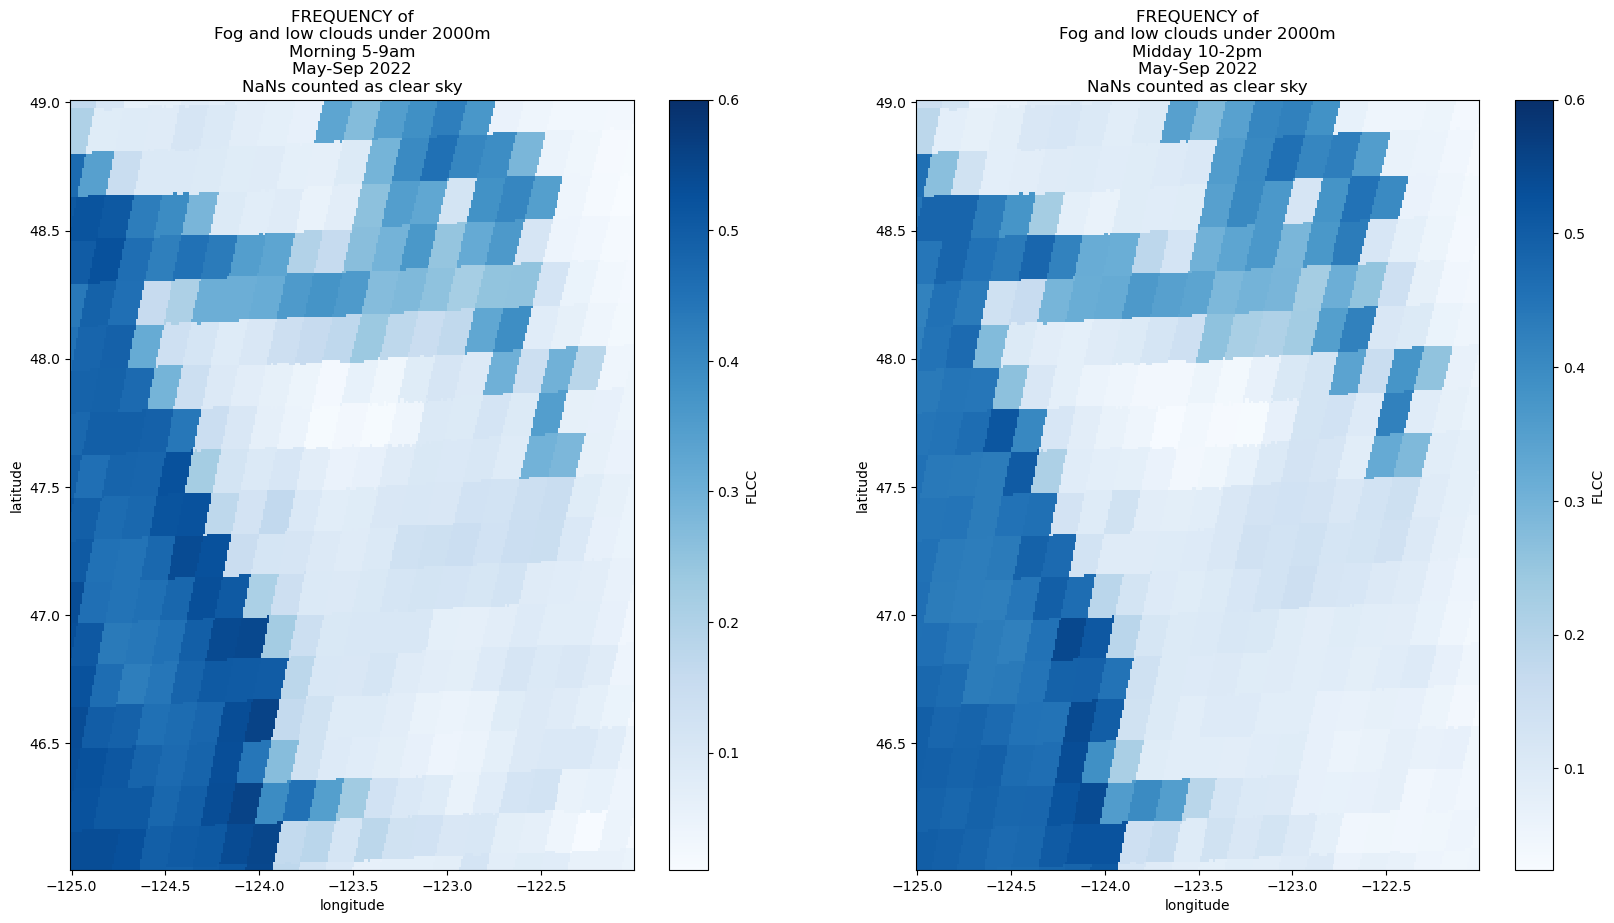

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

morning_freq.plot(ax = ax[0], cmap = 'Blues', vmax = 0.6)
# shoreline.plot(ax = ax[0], color = "black", alpha = 0.5) # how to make the stroke of the shoreline thinner?
ax[0].set_title('FREQUENCY of\nFog and low clouds under 2000m\nMorning 5-9am\nMay-Sep 2022\nNaNs counted as clear sky')

midday_freq.plot(ax = ax[1], cmap = 'Blues', vmax = 0.6)
# shoreline.plot(ax = ax[1], color = "black", alpha = 0.5)
ax[1].set_title('FREQUENCY of\nFog and low clouds under 2000m\nMidday 10-2pm\nMay-Sep 2022\nNaNs counted as clear sky')

TypeError: _AxesBase.set_ylabel() missing 1 required positional argument: 'ylabel'

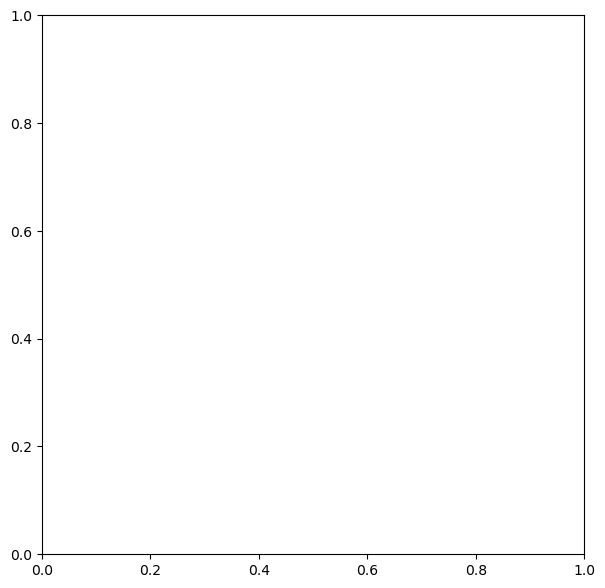

In [ ]:
morning_midday_diff = morning_freq - midday_freq

fig, ax = plt.subplots(figsize=(7,7))
ax.set_ylabel()
morning_midday_diff.plot(ax = ax, cmap = 'coolwarm_r')
# shoreline.plot(ax = ax, color = "darkgreen", alpha = 0.75) # how to make the stroke of the shoreline thinner? -> increase figsize?
plt.title('Difference between morning and midday frequency\nof Fog&Low Clouds under 2000m\nMorning minus Midday\nMay-Sep 2022')

## Frequency by months

In [ ]:
months_ds=[]
for i in range(5,10):
    months_ds.append(ds.isel(time=ds.time.dt.month.isin([i])))
    print(months_ds[i-5]['time'].size)

8060
8632
8892
6995
8206


In [ ]:
months_freq=[]
for i in range(5):
    month_freq = months_ds[i]['FLCC'].sum(dim='time')/months_ds[i]['time'].size
    month_freq.load() # took 12 mins to load May, 6 mins to load June. 34 mins to load all 5 months.
    print(f"Finish loading frequency raster for month {i+5}")
    months_freq.append(month_freq)

Finish loading frequency raster for month 5
Finish loading frequency raster for month 6
Finish loading frequency raster for month 7
Finish loading frequency raster for month 8
Finish loading frequency raster for month 9


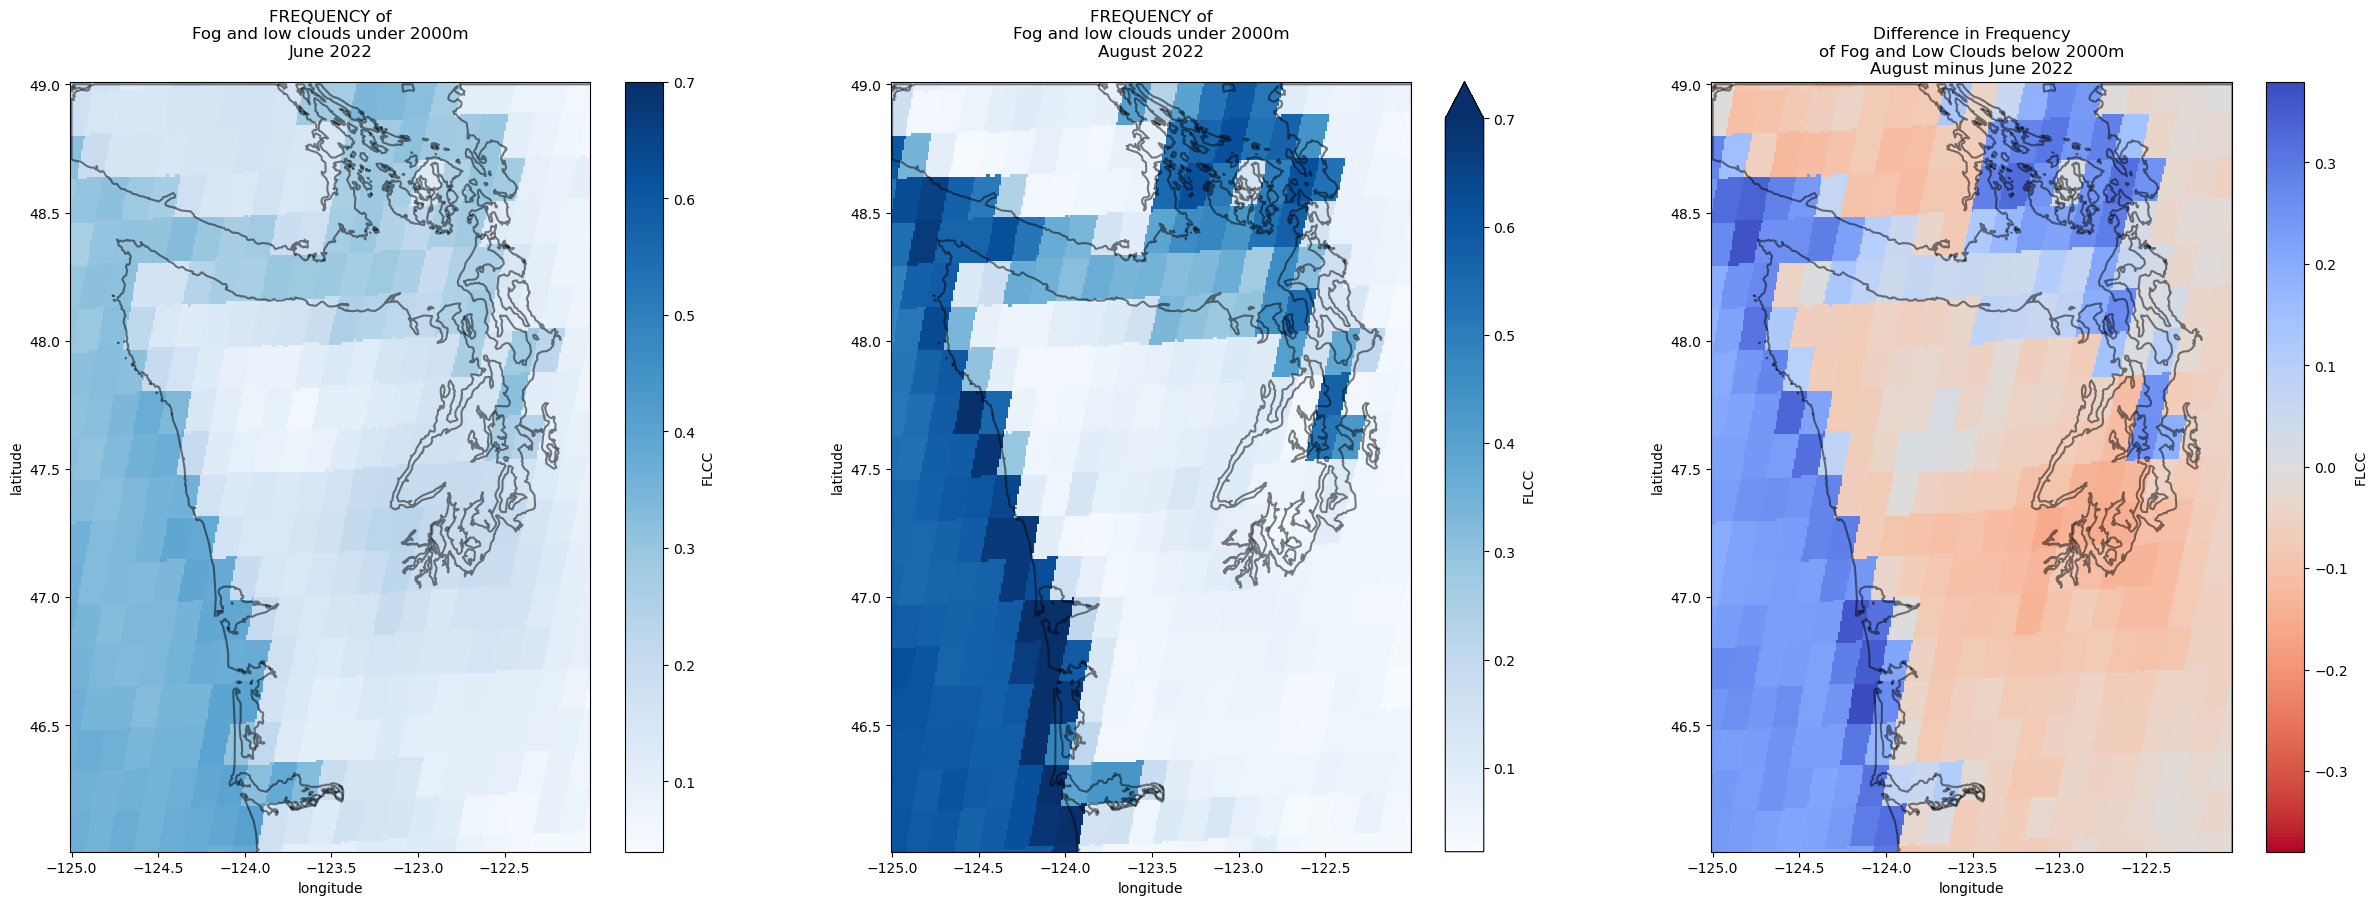

In [ ]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(30,10))
    
months_freq[1].plot(ax = ax[0], cmap = 'Blues', vmax = 0.7)
ax[0].set_title('FREQUENCY of\nFog and low clouds under 2000m\nJune 2022\n')

months_freq[3].plot(ax = ax[1], cmap = 'Blues', vmax = 0.7)
ax[1].set_title('FREQUENCY of\nFog and low clouds under 2000m\nAugust 2022\n')

aug_jun_diff = months_freq[3] - months_freq[1]
aug_jun_diff.plot(ax = ax[2], cmap = 'coolwarm_r')
ax[2].set_title('Difference in Frequency\nof Fog and Low Clouds below 2000m\nAugust minus June 2022')

for ax in ax: # have to do this after plotting the freq, or will have an error "Axes" object is not subscriptables
    shoreline.plot(ax=ax, color = "black", alpha = 0.5)

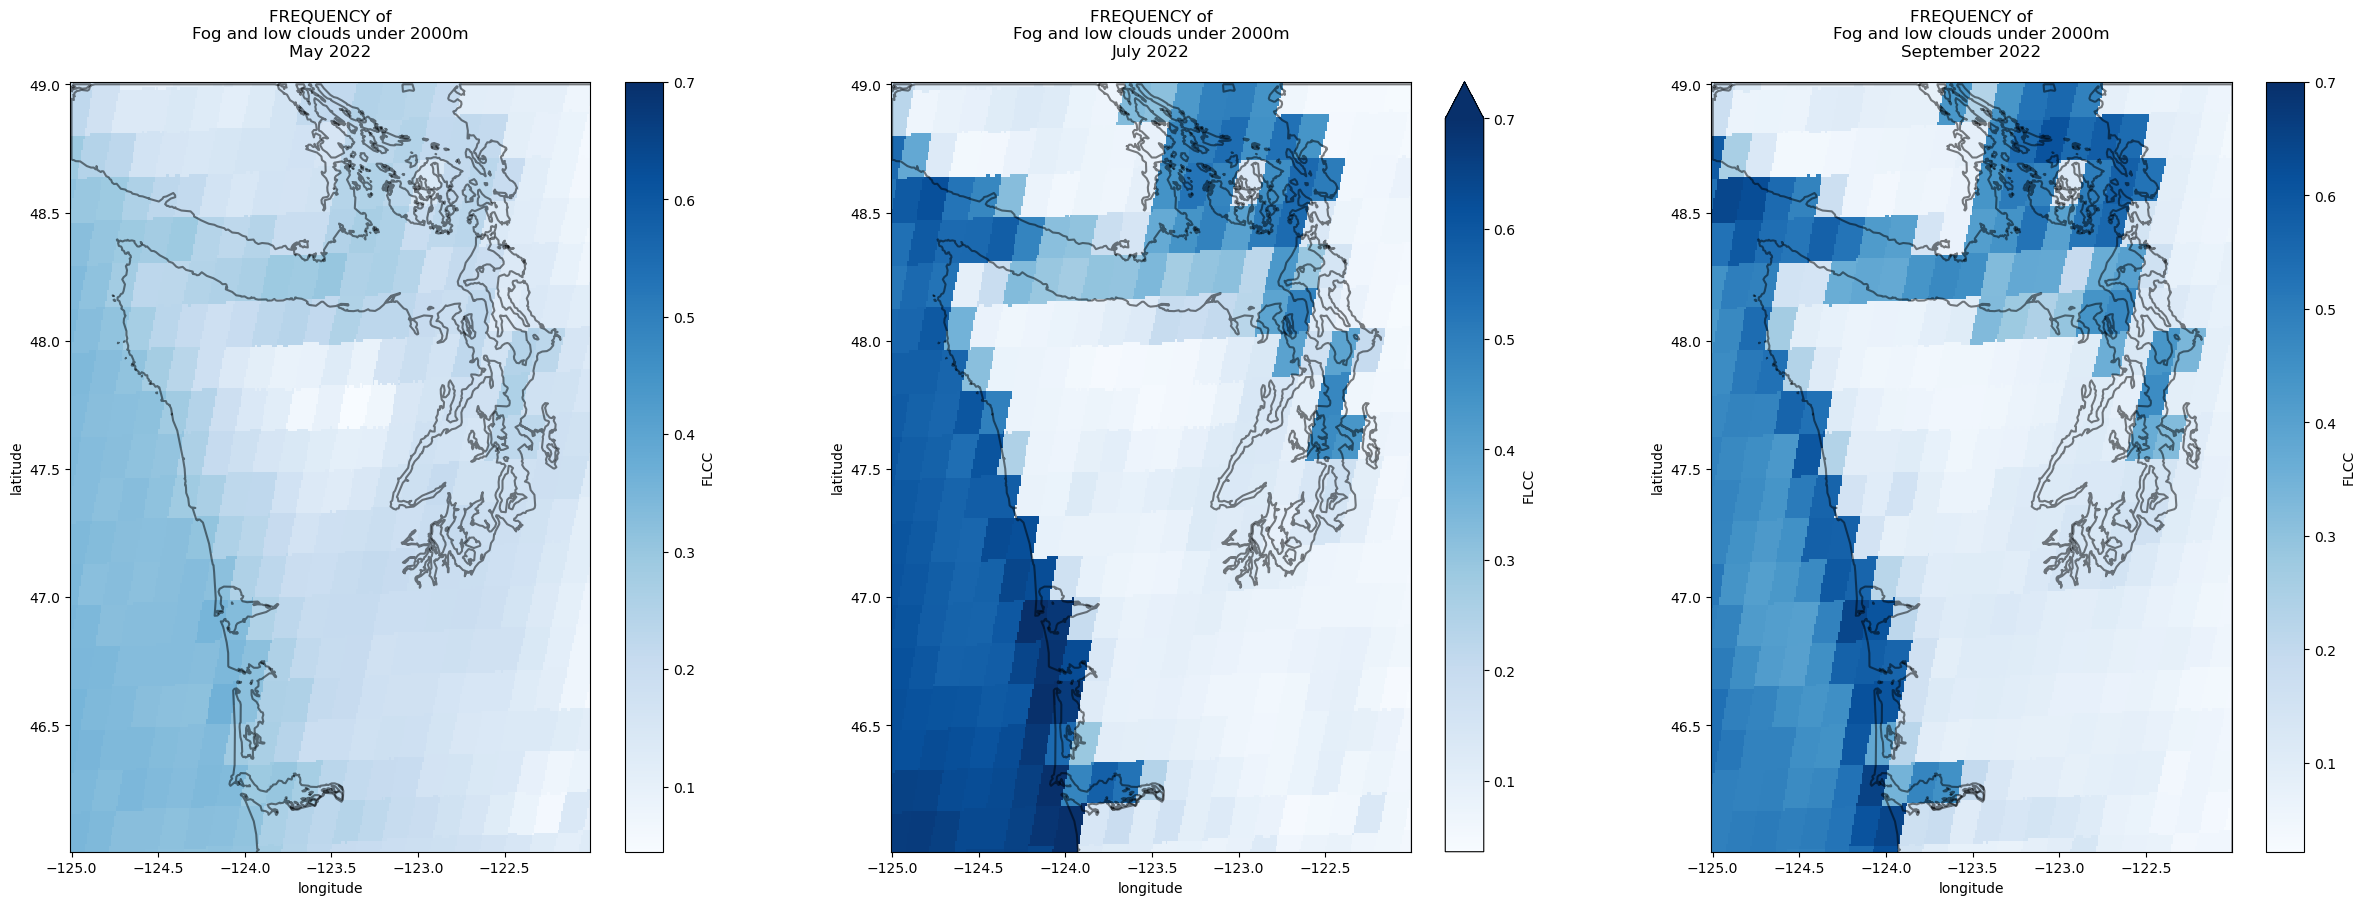

In [ ]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(30,10))
    
months_freq[0].plot(ax = ax[0], cmap = 'Blues', vmax = 0.7)
ax[0].set_title('FREQUENCY of\nFog and low clouds under 2000m\nMay 2022\n')

months_freq[2].plot(ax = ax[1], cmap = 'Blues', vmax = 0.7)
ax[1].set_title('FREQUENCY of\nFog and low clouds under 2000m\nJuly 2022\n')

months_freq[4].plot(ax = ax[2], cmap = 'Blues', vmax = 0.7)
ax[2].set_title('FREQUENCY of\nFog and low clouds under 2000m\nSeptember 2022\n')

for ax in ax: # have to do this after plotting the freq, or will have an error "Axes" object is not subscriptables
    shoreline.plot(ax=ax, color = "black", alpha = 0.5)

## NaN (clear sky) frequency

In [ ]:
ds['nan'] = (ds['Height'].isnull())
nan_freq = (
    ds['nan'].sum(dim='time') / ds['time'].size
)

In [ ]:
nan_freq.load() # over 5 mins to load

<xarray.DataArray 'nan' (latitude: 284, longitude: 284)>
array([[0.28733603, 0.28733603, 0.28733603, ..., 0.34897634, 0.34897634,
        0.34897634],
       [0.28733603, 0.28733603, 0.28733603, ..., 0.34897634, 0.34897634,
        0.34897634],
       [0.28733603, 0.28733603, 0.28733603, ..., 0.34897634, 0.34897634,
        0.34897634],
       ...,
       [0.15081525, 0.15081525, 0.15081525, ..., 0.42616158, 0.42616158,
        0.42616158],
       [0.15081525, 0.15081525, 0.15081525, ..., 0.42616158, 0.42616158,
        0.42616158],
       [0.15081525, 0.15081525, 0.15081525, ..., 0.42616158, 0.42616158,
        0.42616158]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

Text(0.5, 1.0, 'Clear sky frequency\nMay-Sep 2022')

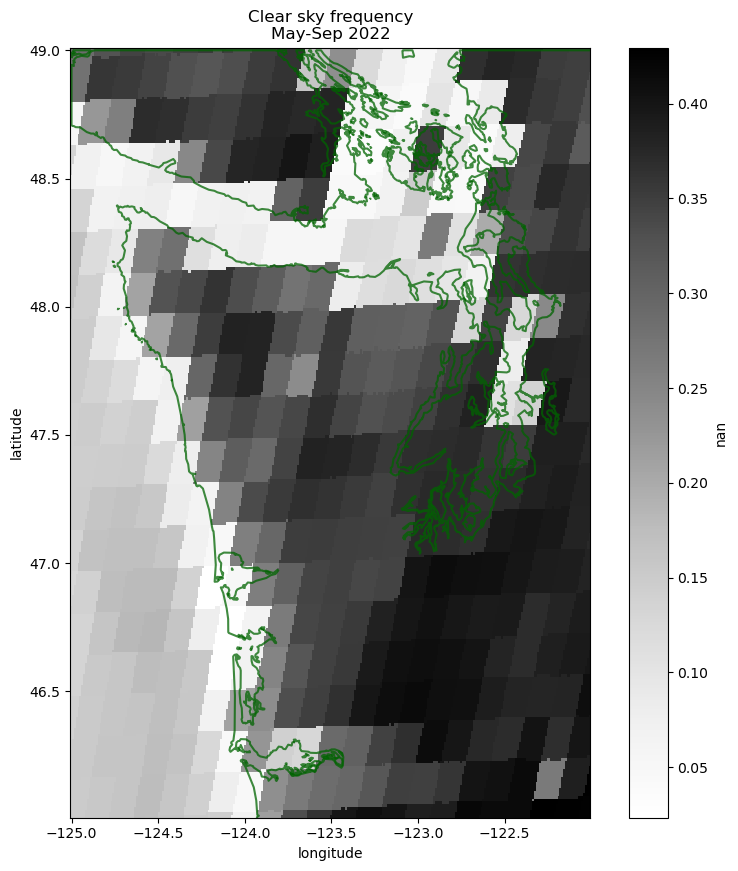

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

nan_freq.plot(ax = ax, cmap = 'Greys')
shoreline.plot(ax = ax, color = "darkgreen", alpha = 0.75) # how to make the stroke of the shoreline thinner? -> increase figsize?
plt.title('Clear sky frequency\nMay-Sep 2022')

## Let's look at the time series at a single point for a few days

In [ ]:
# Longitudes and Latitudes for all the field locations on San Juan Islands
mtdallas = (48.53, -123.13)
cattlepoint = (48.46, -122.96)
falsebay = (48.48, -123.06)
fhl = (48.55, -123.01)

In [ ]:
falsebay_timeseries = ds['Height'].sel(latitude = falsebay[0], longitude = falsebay[1], method='nearest')
falsebay_timeseries

<xarray.DataArray 'Height' (time: 40785)>
dask.array<getitem, shape=(40785,), dtype=float32, chunksize=(40785,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 48.48
    longitude  float64 -123.1
  * time       (time) datetime64[ns] 2022-05-01T00:01:17 ... 2022-09-30T23:51:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

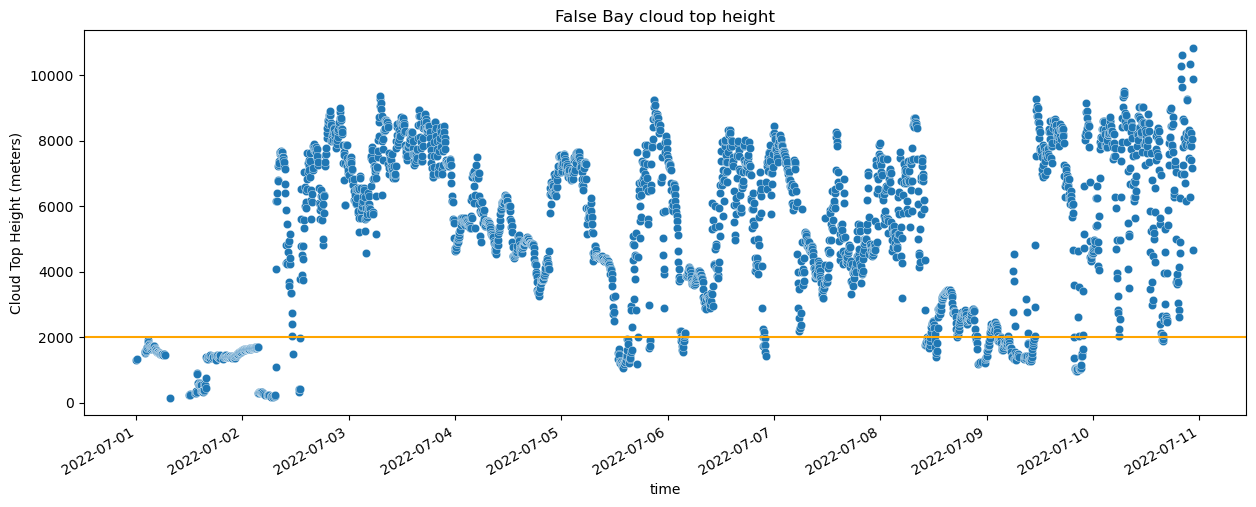

In [ ]:
falsebay_timeseries.sel(time = slice('July 1, 2022', 'July 10, 2022')).plot.scatter('time', figsize=(15,5), linewidths=0.25)
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

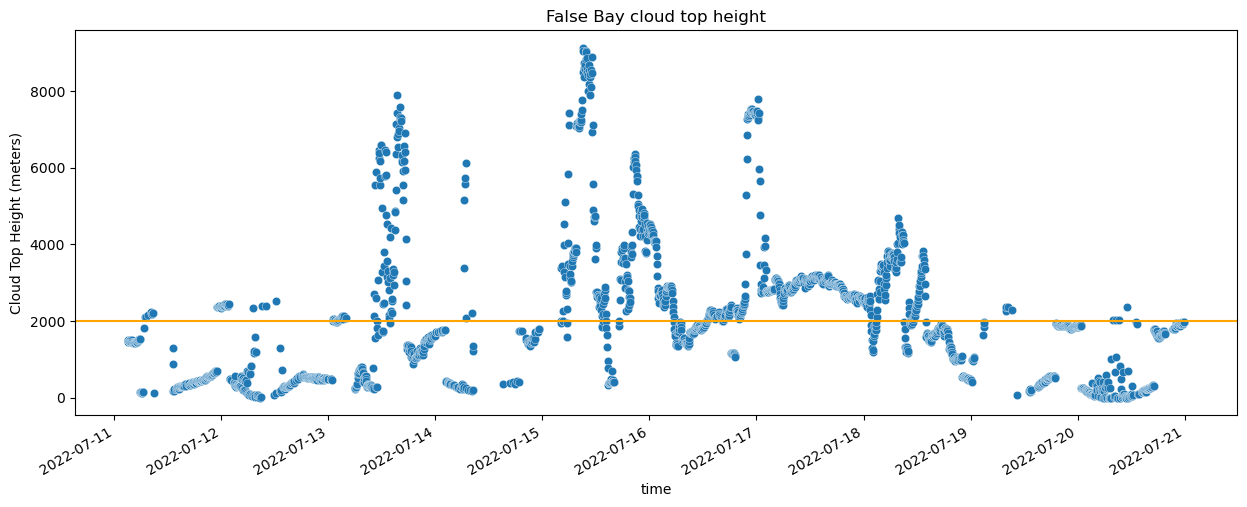

In [ ]:
falsebay_timeseries.sel(time = slice('July 11, 2022', 'July 20, 2022')).plot.scatter('time', figsize=(15,5), linewidths=0.25)
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

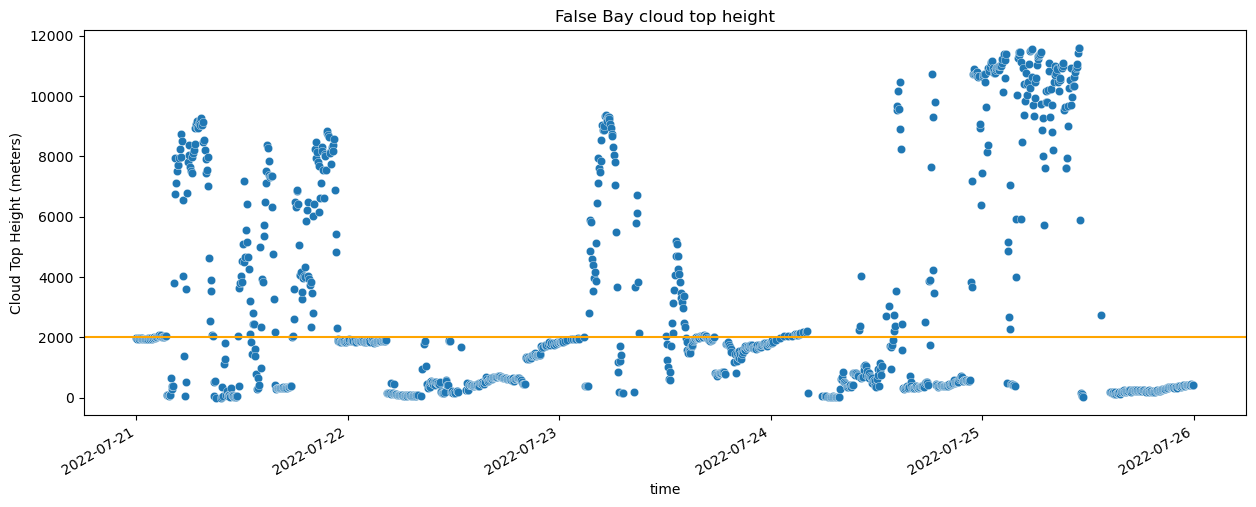

In [ ]:
falsebay_timeseries.sel(time = slice('July 21, 2022', 'July 25, 2022')).plot.scatter('time', figsize=(15,5), linewidths=0.25)
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

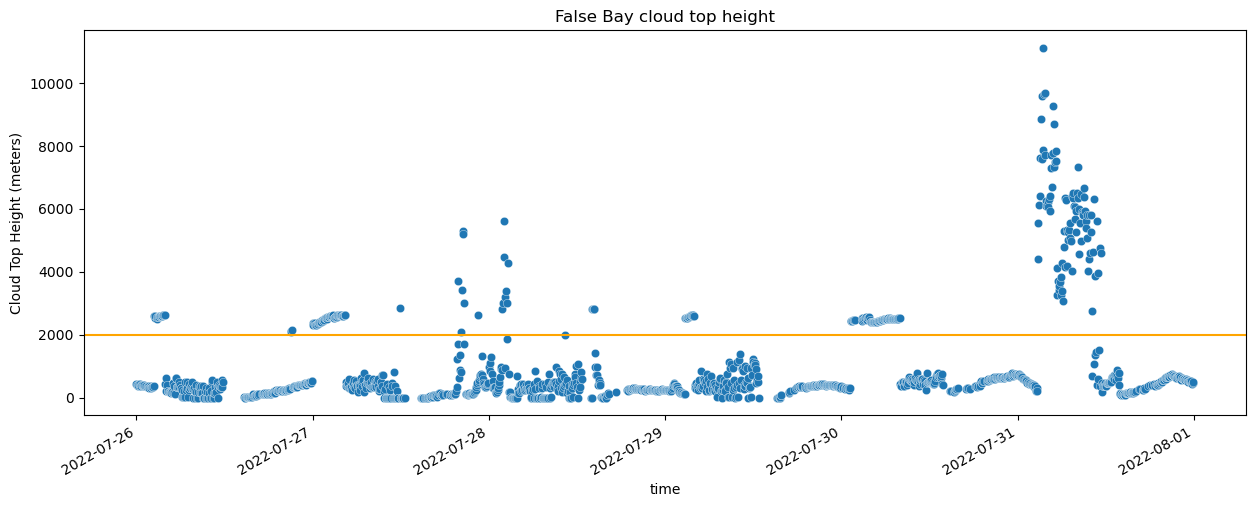

In [ ]:
falsebay_timeseries.sel(time = slice('July 26, 2022', 'July 31, 2022')).plot.scatter('time', figsize=(15,5), linewidths=0.25)
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

### Playground for me to experiment with xarray

In [ ]:
array = xr.DataArray([1, 2, np.nan, 4, np.nan], coords=[("x", [0.1, 0.2, 0.3, 0.4, 0.5])])
# array.isnull().sum()
# array.size
# array.sum()
array.isnull().sum().values

array(2)

In [ ]:
def func(x):
    return x<3

In [ ]:
xr.apply_ufunc(func, array)

<xarray.DataArray (x: 5)>
array([ True,  True, False, False, False])
Coordinates:
  * x        (x) float64 0.1 0.2 0.3 0.4 0.5

In [ ]:
def classify_fog(height):
    # if np.isnan(height):
    #     return np.nan
    # elif height < 400:
    #     return 1
    if height < 400:
        return 1
    else:
        return 0
    